In [13]:
# Load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np
import skfuzzy as fuzz
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the dataset into a DataFrame
music_df = pd.read_csv("music_genre.csv")
print(music_df.head(10))
# Display the shape of the DataFrame
print("Shape of the DataFrame:", music_df.shape)

# Display data types of each column
print("\nData types of each column:")
print(music_df.dtypes)

# Display general information about the DataFrame
print("\nGeneral DataFrame info:")
music_df.info()

   instance_id           artist_name            track_name  popularity  \
0      32894.0              Röyksopp  Röyksopp's Night Out        27.0   
1      46652.0  Thievery Corporation      The Shining Path        31.0   
2      30097.0        Dillon Francis             Hurricane        28.0   
3      62177.0              Dubloadz                 Nitro        34.0   
4      24907.0           What So Not      Divide & Conquer        32.0   
5      89064.0            Axel Boman                 Hello        47.0   
6      43760.0        Jordan Comolli                 Clash        46.0   
7      30738.0                Hraach               Delirio        43.0   
8      84950.0                 Kayzo           NEVER ALONE        39.0   
9      56950.0                Shlump            Lazer Beam        22.0   

   acousticness  danceability  duration_ms  energy  instrumentalness key  \
0       0.00468         0.652         -1.0   0.941          0.792000  A#   
1       0.01270         0.622    

In [3]:
# Check for null values
print("Null values in each column:")
print(music_df.isnull().sum())

# Check for duplicates
duplicates = music_df.duplicated()
print("\nNumber of duplicate rows:", duplicates.sum())

# Display duplicate rows if any
if duplicates.any():
    print("\nDuplicate rows:")
    print(music_df[duplicates])

Null values in each column:
instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
obtained_date       5
valence             5
music_genre         5
dtype: int64

Number of duplicate rows: 4

Duplicate rows:
       instance_id artist_name track_name  popularity  acousticness  \
10001          NaN         NaN        NaN         NaN           NaN   
10002          NaN         NaN        NaN         NaN           NaN   
10003          NaN         NaN        NaN         NaN           NaN   
10004          NaN         NaN        NaN         NaN           NaN   

       danceability  duration_ms  energy  instrumentalness  key  liveness  \
10001           NaN          NaN     NaN               NaN  NaN       NaN   
10002  

In [4]:
# Delete rows with null values
music_df.dropna(inplace=True)
print("After deleting null values, shape of the DataFrame:", music_df.shape)

# Delete duplicate rows
music_df.drop_duplicates(inplace=True)
print("After deleting duplicates, shape of the DataFrame:", music_df.shape)

After deleting null values, shape of the DataFrame: (50000, 18)
After deleting duplicates, shape of the DataFrame: (50000, 18)


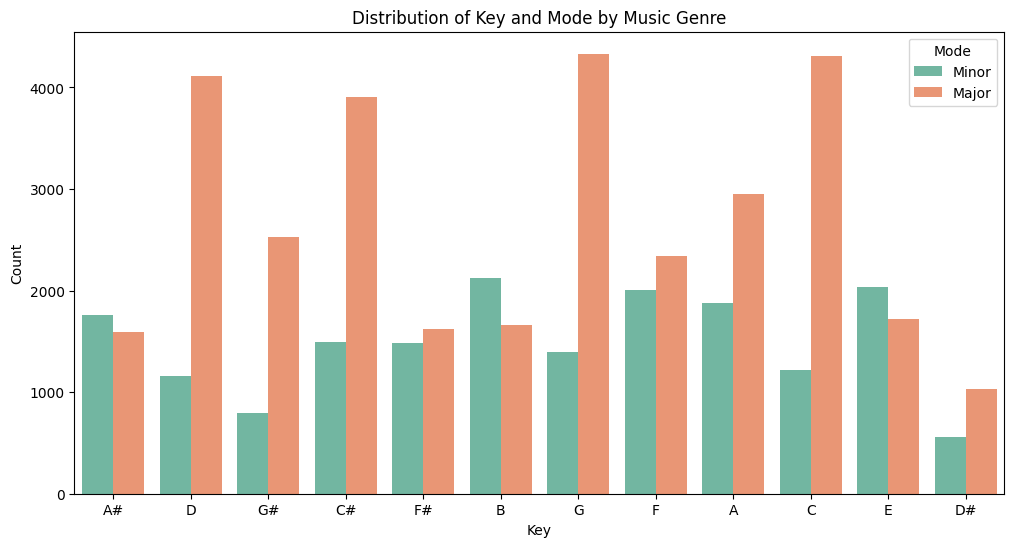

In [5]:
# Create a bar plot
plt.figure(figsize=(12, 6))
sns.countplot(data=music_df, x='key', hue='mode', palette='Set2')

# Add labels and title
plt.title("Distribution of Key and Mode by Music Genre")
plt.xlabel("Key")
plt.ylabel("Count")
plt.legend(title="Mode")

# Show the plot
plt.show()

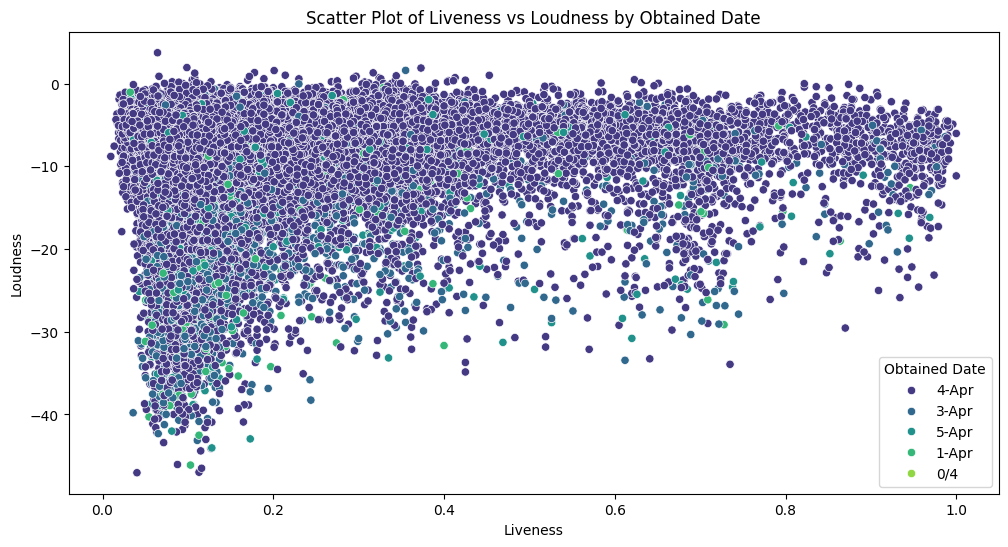

In [6]:
# Create a scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=music_df, x='liveness', y='loudness', hue='obtained_date', palette='viridis')

# Add labels and title
plt.title("Scatter Plot of Liveness vs Loudness by Obtained Date")
plt.xlabel("Liveness")
plt.ylabel("Loudness")
plt.legend(title="Obtained Date")

# Show the plot
plt.show()

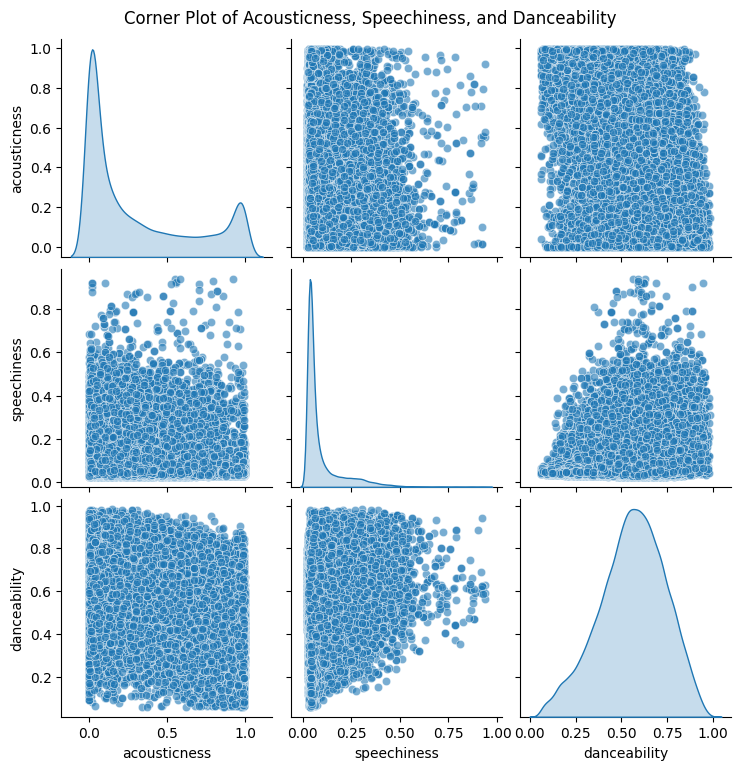

In [7]:
# Select the columns for the pair plot
selected_columns = ['acousticness', 'speechiness', 'danceability']

# Create the pair plot
sns.pairplot(music_df[selected_columns], diag_kind='kde', plot_kws={'alpha': 0.6})

# Add title
plt.suptitle("Corner Plot of Acousticness, Speechiness, and Danceability", y=1.02)

# Show the plot
plt.show()

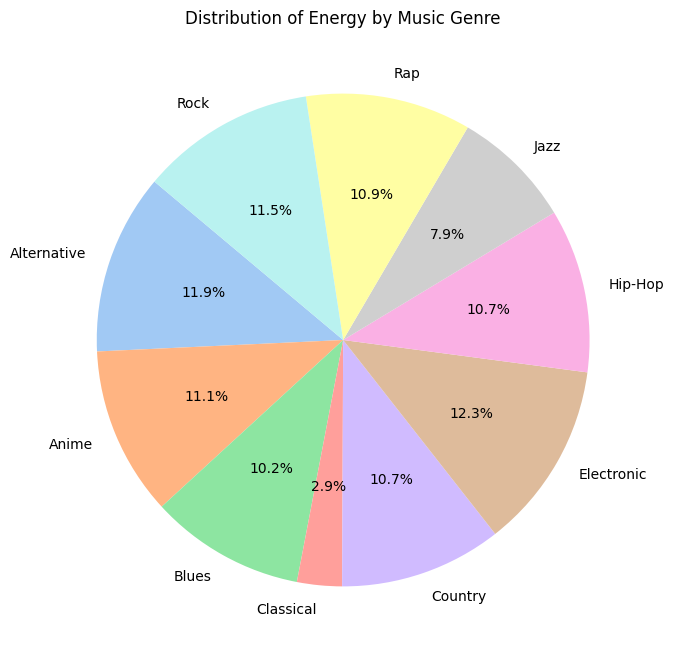

In [8]:
# Group data by music genre and sum energy
energy_by_genre = music_df.groupby('music_genre')['energy'].sum()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(energy_by_genre, labels=energy_by_genre.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))

# Add title
plt.title("Distribution of Energy by Music Genre")

# Show the plot
plt.show()

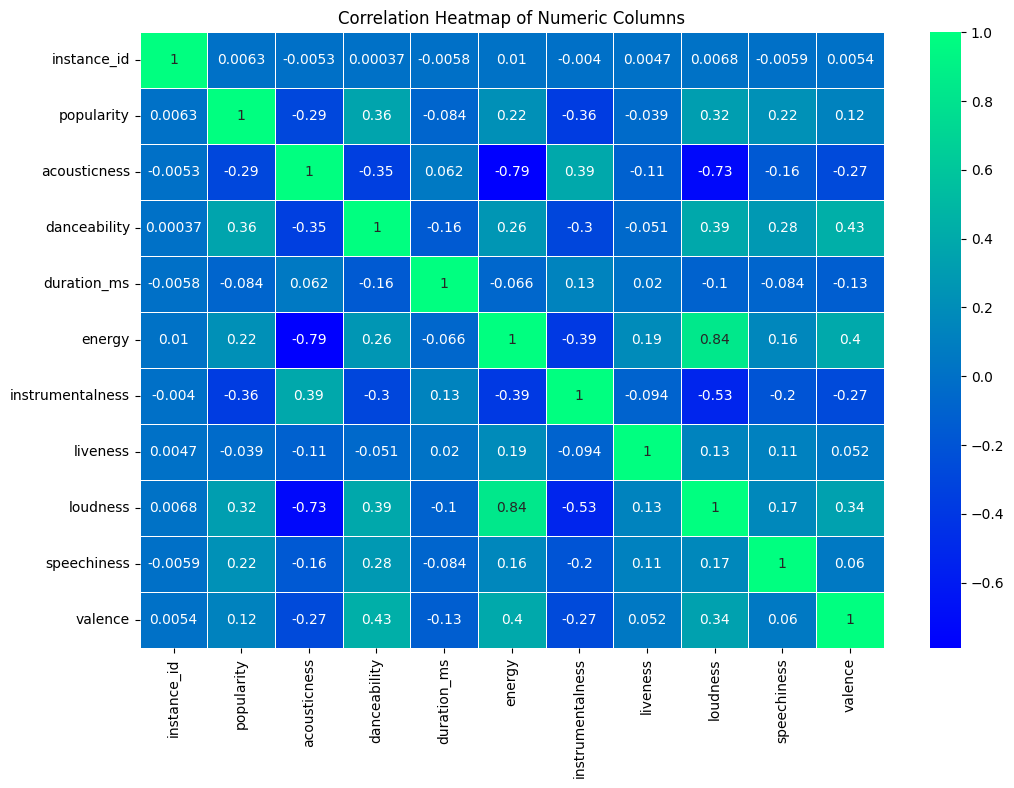

In [9]:
# Select numeric columns
numeric_columns = music_df.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='winter', linewidths=0.5)

# Add title
plt.title("Correlation Heatmap of Numeric Columns")

# Show the plot
plt.show()

In [10]:
# Initialise the LabelEncoder
label_encoder = LabelEncoder()

# Select all columns with object data type (categorical columns)
object_columns = music_df.select_dtypes(include=['object']).columns

# Apply label encoding to all object columns
for column in object_columns:
    music_df[column] = label_encoder.fit_transform(music_df[column])

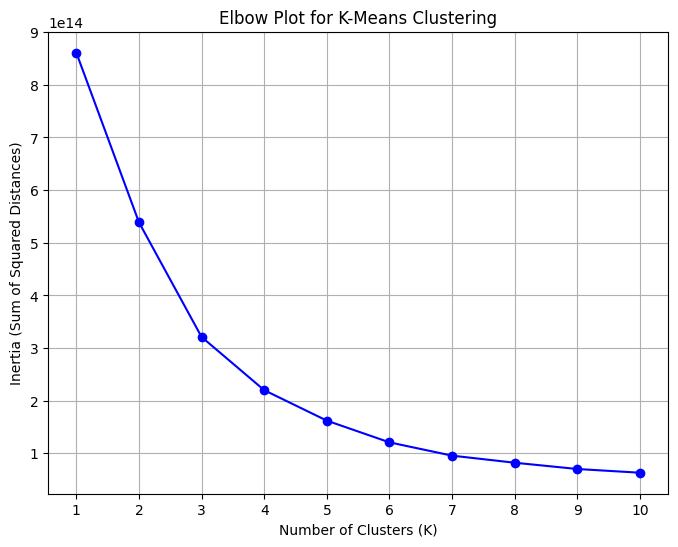


Cluster centers:
[[ 5.57846368e+04  3.58445590e+03  2.10318899e+04  4.11237940e+01
   3.80983796e-01  5.44573774e-01  3.31723956e+04  5.34441008e-01
   2.62811852e-01  5.37464329e+00  1.93811659e-01 -1.08067350e+01
   3.57249626e-01  9.91900394e-02  1.61670001e+04  2.88802826e+00
   4.42076206e-01]
 [ 5.54494260e+04  3.56425118e+03  2.15027031e+04  3.65876777e+01
   4.97754805e-01  4.31962699e-01  4.98479454e+05  4.37338688e-01
   4.54399799e-01  5.29495400e+00  2.08431921e-01 -1.40179205e+01
   3.86674101e-01  6.32221076e-02  1.56402657e+04  2.84750488e+00
   3.13585921e-01]
 [ 5.59482661e+04  3.59142349e+03  2.05712237e+04  4.55049675e+01
   2.74748542e-01  5.72414570e-01  2.31230314e+05  6.26979416e-01
   1.41242116e-01  5.35607108e+00  1.92577374e-01 -8.36992398e+00
   3.55533364e-01  9.53194679e-02  1.58840751e+04  2.93048087e+00
   4.72042628e-01]]

Cluster Distribution by Music Genre:
cluster  music_genre
0        1              1100
         3              1070
         7     

In [11]:
# Separate the features (X) and the target variable (y)
X = music_df.drop(columns=['music_genre'])
y = music_df['music_genre']

# Determine the range of number of clusters for the elbow plot
inertia = []  # List to store the inertia

# Try different values of K (from 1 to 10) and calculate inertia
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Create the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.title("Elbow Plot for K-Means Clustering")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# Choose the optimal number of clusters (K)
optimal_k = 3

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
music_df['cluster'] = kmeans.fit_predict(X)

# Print the cluster centers
print("\nCluster centers:")
print(kmeans.cluster_centers_)

# Analyze the distribution of clusters
cluster_distribution = music_df.groupby('cluster')['music_genre'].value_counts()
print("\nCluster Distribution by Music Genre:")
print(cluster_distribution)

Silhouette Score for Fuzzy C-Means: 0.39852436427851434


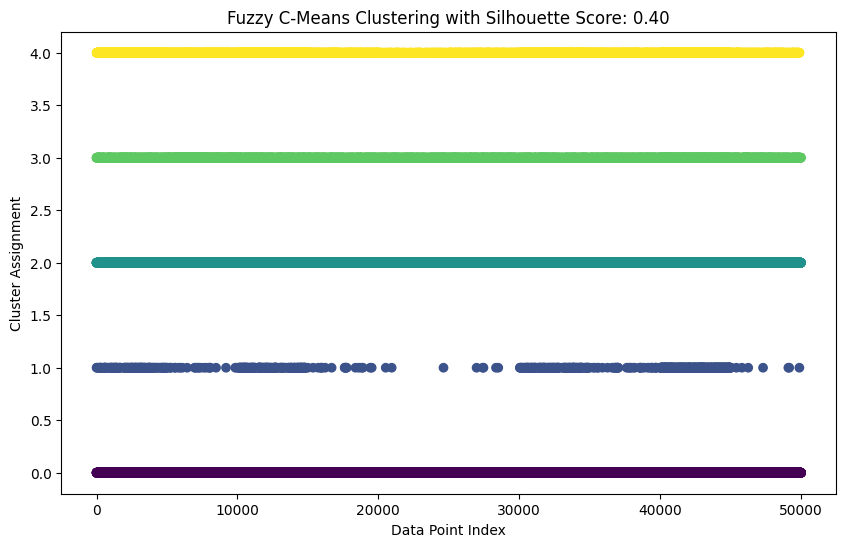

In [14]:
# Select the features (X) excluding the 'music_genre' column
X = music_df.drop(columns=['music_genre'])

# Transpose the data if needed for Fuzzy C-Means
X = X.values.T

# Set up the Fuzzy C-Means parameters
n_clusters = 5  # Choose the number of clusters based on prior knowledge or analysis
max_iter = 150
error = 0.0001  # Desired convergence threshold

# Perform Fuzzy C-Means clustering
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X, n_clusters, 2, error=error, maxiter=max_iter)

# Get the cluster assignments (highest membership value for each data point)
cluster_assignments = np.argmax(u, axis=0)

# Add the cluster labels to the original DataFrame
music_df['fcm_cluster'] = cluster_assignments

# Compute silhouette score to evaluate clustering
silhouette_avg = silhouette_score(X.T, cluster_assignments)
print(f"Silhouette Score for Fuzzy C-Means: {silhouette_avg}")

# Plot the silhouette plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(cluster_assignments)), cluster_assignments, c=cluster_assignments, cmap='viridis', marker='o')
plt.title(f"Fuzzy C-Means Clustering with Silhouette Score: {silhouette_avg:.2f}")
plt.xlabel("Data Point Index")
plt.ylabel("Cluster Assignment")
plt.show()

Number of clusters: 0
Number of noise points: 50000


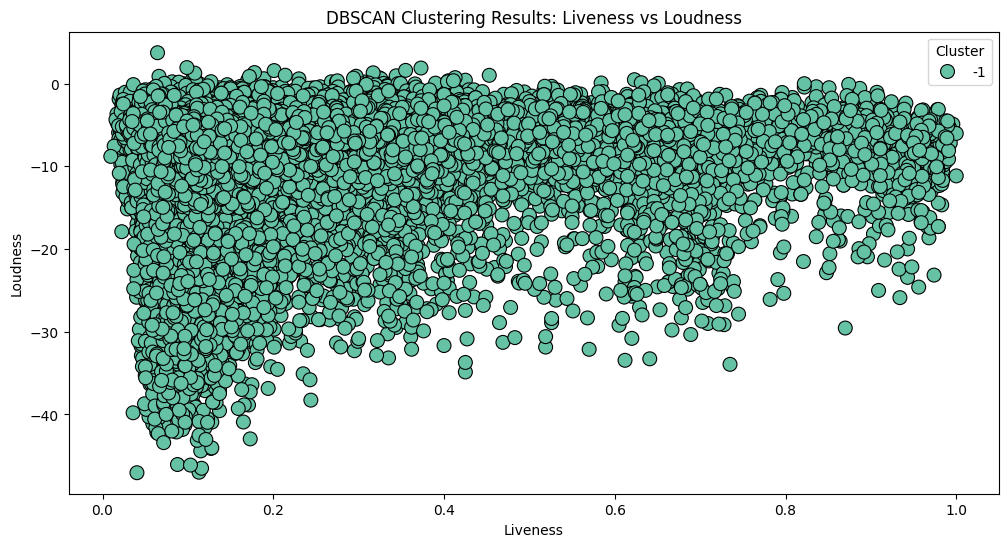

In [15]:
# Select numeric columns
X = music_df.select_dtypes(include='number')

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
music_df['dbscan_cluster'] = dbscan.fit_predict(X)

# Print the number of clusters and noise points
print(f"Number of clusters: {len(set(music_df['dbscan_cluster'])) - (1 if -1 in music_df['dbscan_cluster'].values else 0)}")
print(f"Number of noise points: {(music_df['dbscan_cluster'] == -1).sum()}")

# Create a scatter plot of DBSCAN clustering result
plt.figure(figsize=(12, 6))
sns.scatterplot(data=music_df, x='liveness', y='loudness', hue='dbscan_cluster', palette='Set2', s=100, edgecolor='black')

# Add labels and title
plt.title("DBSCAN Clustering Results: Liveness vs Loudness")
plt.xlabel("Liveness")
plt.ylabel("Loudness")
plt.legend(title="Cluster")

# Show the plot
plt.show()


Mean Squared Error (MSE): 0.012779267265370863
R-squared (R2): 0.8174566781757319


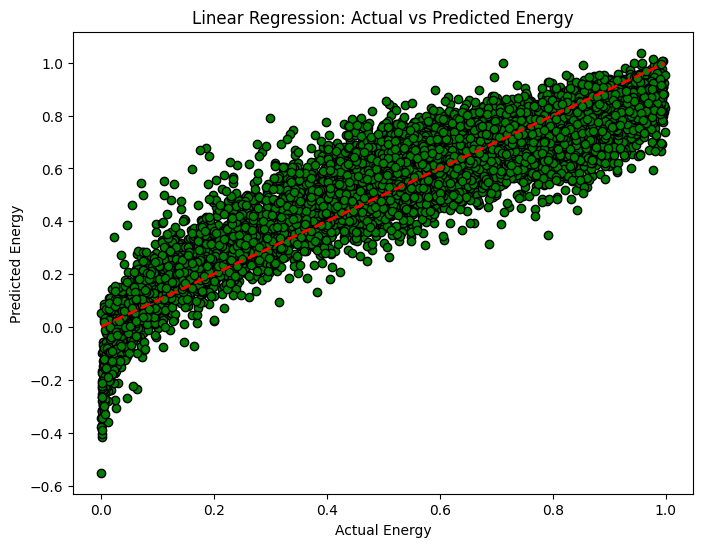

In [16]:
# Select the features (X) and target variable (y)
X = music_df.drop(columns=['energy'])  # Features
y = music_df['energy']  # Target: 'energy'

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialise the Linear Regression model
linear_reg_model = LinearRegression()

# Train the model
linear_reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear_reg_model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='green', edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title("Linear Regression: Actual vs Predicted Energy")
plt.xlabel("Actual Energy")
plt.ylabel("Predicted Energy")
plt.show()